In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

#### Steps 6 and 7 of part II of Lab 12

In [2]:
%%time

# M is the total number of runs
M=500

#N is the size of trajectory
N = 500

Errors_prediction_squared_x = np.zeros((M, N))
Errors_filtration_squared_x = np.zeros((M, N))
Errors_prediction_squared_y = np.zeros((M, N))
Errors_filtration_squared_y = np.zeros((M, N))
Errors_prediction_squared_theta = np.zeros((M, N))
Errors_filtration_squared_theta = np.zeros((M, N))


for j in range(M):

    #T is the interval between measurements
    T = 0.05

    #Theta is array of orientation angle
    theta = np.loadtxt('theta.txt')

    #Noise of acceleration
    sigma_a = 1
    a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
    a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

    #Now let's create the trajectory
    x = np.zeros(N)
    x[0] = 0

    y = np.zeros(N)
    y[0] = 0

    v_x = np.zeros(N)
    v_y = np.zeros(N)
    v0 = 10

    for i in range(N):
        v_x[i] = v0 * np.cos(theta[i])
        v_y[i] = v0 * np.sin(theta[i])

    for i in range(1,N):
        x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
        y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2

    #Noise of measurements
    sigma_eta_x = 3
    sigma_eta_y = 3
    eta_x = np.random.normal(loc=0.0, scale=sigma_eta_x, size=N)
    eta_y = np.random.normal(loc=0.0, scale=sigma_eta_y, size=N)

    #Now let's generate measurements
    z_x = np.zeros(N)
    z_y = np.zeros(N)
    for i in range(N):
        z_x[i] = x[i] + eta_x[i]
        z_y[i] = y[i] + eta_y[i]

    #Noise of velocity measurements
    sigma_eta_v = 0.5
    eta_v = np.random.normal(loc=0.0, scale=sigma_eta_v, size=N)

    #Now let's generate measurements
    v_m = np.zeros(N)
    for i in range(N):
        v_m[i] = v0 + eta_v[i]

    #Noise of angle measurements
    sigma_eta_theta = 0.02
    eta_theta = np.random.normal(loc=0.0, scale=sigma_eta_theta, size=N)

    #Now let's generate measurements
    theta_m = np.zeros(N)
    for i in range(N):
        theta_m[i] = theta[i] + eta_theta[i]

    #Making state vector
    X = np.zeros((N, 4, 1))
    for i in range(N):
        X[i] = np.matrix([[x[i]],
                          [v_x[i]],
                          [y[i]],
                          [v_y[i]]])
    #Initial state vector
    X[2] = np.matrix([[z_x[1]],
                      [(z_x[1] - z_x[0]) / T],
                      [z_y[1]],
                      [(z_y[1] - z_y[0]) / T]])

    #Making filtration error covariance matrix P
    P = np.zeros((N, 4, 4))
    for i in range(N):
        P[i] = np.matrix([[0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0]])

    #Initial filtration error covariance matrix
    P[0] = 10**4 * np.identity(4)

    #Making a transition matrix
    PHI = np.matrix([[1, T, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, T],
                     [0, 0, 0, 1]])

    #Making an input matrix
    G = np.matrix([[0.5 * T**2, 0],
                   [T, 0],
                   [0, 0.5 * T**2],
                   [0, T]])

    #Calculating state noise covariance matrix Q
    Q = 25 * G @ G.T

    #Making measurement error covariance matrix R
    R = np.matrix([[sigma_eta_x**2, 0, 0, 0],
                   [0, sigma_eta_y**2, 0, 0],
                   [0, 0, sigma_eta_v**2, 0],
                   [0, 0, 0, sigma_eta_theta**2]])

    # Let's start Kalman filter algorithm
    x_Kalman_Predict = np.zeros(N)
    y_Kalman_Predict = np.zeros(N)
    x_Kalman_Filter = np.zeros(N)
    y_Kalman_Filter = np.zeros(N)
    vx_Kalman_Predict = np.zeros(N)
    vy_Kalman_Predict = np.zeros(N)
    vx_Kalman_Filter = np.zeros(N)
    vy_Kalman_Filter = np.zeros(N)
    dhdx = np.zeros((N, 2, 4))

    K = np.zeros((N, 4, 4))
    e = np.zeros((N, 2, 2))

    #Making nonlinear function h, the derivative and measurement vector
    h = np.zeros((N, 4, 1))
    dhdx = np.zeros((N, 4, 4))
    z = np.zeros((N, 4, 1))

    sqrt = np.zeros(N)

    for i in range(2, N-1):

        #Prediction of the state vector
        X[i+1] = PHI @ X[i]
        x_Kalman_Predict[i+1] = X[i+1,0]
        vx_Kalman_Predict[i+1] = X[i+1,1]
        y_Kalman_Predict[i+1] = X[i+1,2]
        vy_Kalman_Predict[i+1] = X[i+1,3]
        sqrt[i+1] = (vx_Kalman_Predict[i+1]**2 + vy_Kalman_Predict[i+1]**2) ** 0.5

        dhdx[i+1] = np.matrix([[1, 0, 0, 0],
                               [0, 0, 1, 0],
                               [0, vx_Kalman_Predict[i+1] / sqrt[i+1], 0, vy_Kalman_Predict[i+1]/sqrt[i+1]],
                               [0, -vy_Kalman_Predict[i+1] / (sqrt[i+1]**2), 0, vx_Kalman_Predict[i+1] / (sqrt[i+1]**2)]])

        #Prediction error covariance matrix
        P[i+1] = PHI @ P[i] @ PHI.T + Q

        #Filtration
        K[i+1] = P[i+1] @ dhdx[i+1].T @ np.linalg.inv(dhdx[i+1] @ P[i+1] @ dhdx[i+1].T + R)
        h[i+1] = np.matrix([[x_Kalman_Predict[i+1]],
                            [y_Kalman_Predict[i+1]],
                            [sqrt[i+1]],
                            [np.arctan2(vy_Kalman_Predict[i+1], vx_Kalman_Predict[i+1])]])
        z[i+1] = np.matrix([[z_x[i+1]], 
                          [z_y[i+1]],
                          [v_m[i+1]],
                          [theta_m[i+1]]])
        X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - h[i+1])
        x_Kalman_Filter[i+1] = X[i+1,0]
        vx_Kalman_Filter[i+1] = X[i+1,1]
        y_Kalman_Filter[i+1] = X[i+1,2]
        vy_Kalman_Filter[i+1] = X[i+1,3]

        #Filtration error covariance matrix
        P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ dhdx[i+1]) @ P[i+1]
        
        #Gathering errors
        for i in range(4,N-1):
            Errors_prediction_squared_x[j, i] = (x_Kalman_Predict[i] - z_x[i]) ** 2
            Errors_filtration_squared_x[j, i] = (x_Kalman_Filter[i] - z_x[i]) ** 2
            Errors_prediction_squared_y[j, i] = (y_Kalman_Predict[i] - z_y[i]) ** 2
            Errors_filtration_squared_y[j, i] = (y_Kalman_Filter[i] - z_y[i]) ** 2
            Errors_prediction_squared_theta[j, i] = (np.arctan2(vy_Kalman_Predict[i], vx_Kalman_Predict[i]) - theta_m[i]) ** 2
            Errors_filtration_squared_theta[j, i] = (np.arctan2(vy_Kalman_Filter[i], vx_Kalman_Filter[i]) - theta_m[i]) ** 2
            
            
Fin_Errors_prediction_squared_x = np.zeros(N)
Fin_Errors_filtration_squared_x = np.zeros(N)
Fin_Errors_prediction_squared_y = np.zeros(N)
Fin_Errors_filtration_squared_y = np.zeros(N)
Fin_Errors_prediction_squared_theta = np.zeros(N)
Fin_Errors_filtration_squared_theta = np.zeros(N)
for i in range(3, N-1):
    for j in range(M):
        Fin_Errors_prediction_squared_x[i] += (1/(M-1)) * Errors_prediction_squared_x[j, i]
        Fin_Errors_filtration_squared_x[i] += (1/(M-1)) * Errors_filtration_squared_x[j, i]
        Fin_Errors_prediction_squared_y[i] += (1/(M-1)) * Errors_prediction_squared_y[j, i]
        Fin_Errors_filtration_squared_y[i] += (1/(M-1)) * Errors_filtration_squared_y[j, i]
        Fin_Errors_prediction_squared_theta[i] += (1/(M-1)) * Errors_prediction_squared_theta[j, i]
        Fin_Errors_filtration_squared_theta[i] += (1/(M-1)) * Errors_filtration_squared_theta[j, i]

Wall time: 20min 5s


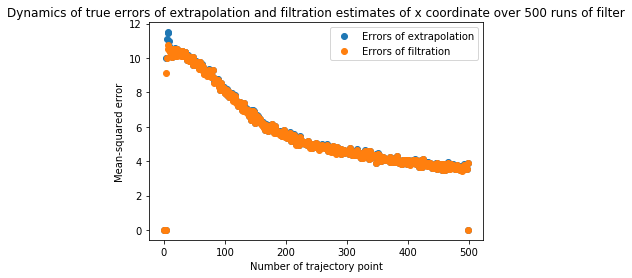

In [3]:
plt.plot(np.sqrt(Fin_Errors_prediction_squared_x), 'o')
plt.plot(np.sqrt(Fin_Errors_filtration_squared_x), 'o')
plt.title('Dynamics of true errors of extrapolation and filtration estimates of x coordinate over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

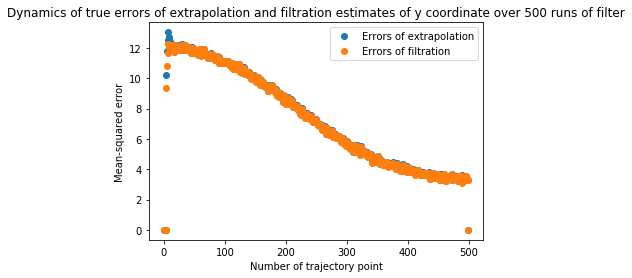

In [4]:
plt.plot(np.sqrt(Fin_Errors_prediction_squared_y), 'o')
plt.plot(np.sqrt(Fin_Errors_filtration_squared_y), 'o')
plt.title('Dynamics of true errors of extrapolation and filtration estimates of y coordinate over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

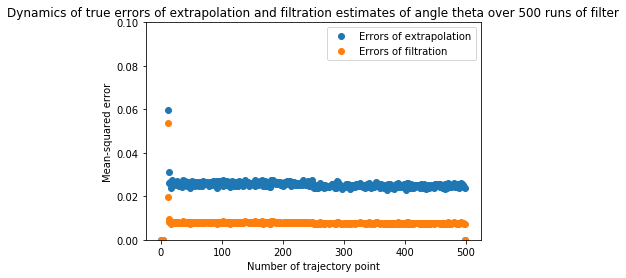

In [5]:
plt.plot(np.sqrt(Fin_Errors_prediction_squared_theta), 'o')
plt.plot(np.sqrt(Fin_Errors_filtration_squared_theta), 'o')
plt.title('Dynamics of true errors of extrapolation and filtration estimates of angle theta over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.ylim((0,0.1))
plt.show()

# Conclusion
Proper usage of additional sources of information make filters work more precisely